### Detecção de Fake News em Língua Portuguesa Combinando Redes Neurais Convolucionais e Algoritmos de Aprendizagem de Máquina

Proposta para a análise de notícias em Português e a detecção de fake news, utilizando Aprendizagem de Máquina e Redes Neurais Convolucionais. 

O dataset a ser utilizado é a base de dados Fake.Br, que foi construída por pesquisadores da Universidade de São Paulo (USP) e apresenta 7.200 artigos de notícias em português. O estudo realizado concentrou-se em analisar tanto os textos, como também os seus respectivos metadados.

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import git
import seaborn as sns
import sklearn.metrics as metrics
import fasttext.util
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, Masking
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from gensim.models import KeyedVectors

from tqdm.notebook import tqdm
from glob import glob
from scipy.stats import zscore
from nlp_utils import extract_data, preprocessing, word_vec_matrix, word_count

In [39]:
# Verifica a existência de GPUs
gpu = tf.config.list_physical_devices('GPU')
if gpu:
    # Mostra informações sobre a GPU
    name = tf.config.experimental.get_device_details(gpu[0])['device_name']
    print("GPU disponível:", name)
else:
    print("GPU não está disponível")

GPU disponível: NVIDIA GeForce RTX 2060


In [40]:
repo_url = 'https://github.com/roneysco/Fake.br-Corpus.git'

if not os.path.exists('fake_br'):
    repo = git.Repo.clone_from(repo_url, 'fake_br')

In [41]:
folder = r'fake_br/full_texts/'

In [42]:
fake_news = extract_data(folder, 'fake')
true_news = extract_data(folder, 'true')
fake_br = np.array(fake_news + true_news)

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

### Pré-processamento do texto

Nesta etapa, é realizada a padronização do texto, remoção de stopwords e eliminação de ruídos e caracteres estranhos. Este processo é importante para garantir a qualidade dos dados para o treinamento.

In [43]:
news = preprocessing(fake_br[:, 0])
y = fake_br[:, 1]

  0%|          | 0/7200 [00:00<?, ?it/s]

In [44]:
palavras_fake = word_count(news[:len(news) // 2])
palavras_true = word_count(news[len(news) // 2:])
palavras_geral = word_count(news)

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/7200 [00:00<?, ?it/s]

In [45]:
# Removendo outliers com Z-Score
limite_zscore = 2  # Defina um limite adequado

def calcular_metricas(palavras):
    palavras_sem_outliers = palavras[np.abs(zscore(palavras)) < limite_zscore]
    media = np.mean(palavras_sem_outliers)
    mediana = np.median(palavras_sem_outliers)
    desvio_padrao = np.std(palavras_sem_outliers)
    _min = palavras.min().astype(int)
    _max = palavras.max().astype(int)
    return media, mediana, desvio_padrao, _min, _max

media_palavras_fake, mediana_palavras_fake, desvio_palavras_fake, min_fake, max_fake = calcular_metricas(palavras_fake)
media_palavras_true, mediana_palavras_true, desvio_palavras_true, min_true, max_true = calcular_metricas(palavras_true)
media_palavras_geral, mediana_palavras_geral, desvio_palavras_geral, min_geral, max_geral = calcular_metricas(palavras_geral)


In [46]:
data = {
    'Métrica': ['Média', 'Mediana', 'Desvio padrão', 'Mínimo', 'Máximo'],
    'Fake News': [media_palavras_fake, mediana_palavras_fake, desvio_palavras_fake, min_fake, max_fake],
    'Verdadeiras': [media_palavras_true, mediana_palavras_true, desvio_palavras_true, min_true, max_true],
    'Geral': [media_palavras_geral, mediana_palavras_geral, desvio_palavras_geral, min_geral, max_geral]
}

df = pd.DataFrame(data, dtype = int)

# Exibir o DataFrame formatado sem os números de linha
display(df.style.hide_index())

Métrica,Fake News,Verdadeiras,Geral
Média,96.694500,570.865324,303.644906
Mediana,89.000000,504.000000,181.000000
Desvio padrão,44.704503,288.434650,271.337263
Mínimo,5,14,5
Máximo,1166,4134,4134


### Transformação

Para que sejam processados pelos algoritmos de AM, é necessário que antes os textos sejam convertidos do formato textual para uma representação numérica. Nesta etapa, os textos foram submetidos a um processo de vetorização, que consiste em converter cada termo contido no texto  m um valor numérico. Desta forma, cada texto é representado por um vetor contendo todos os valores numéricos que representam cada um dos termos contidos nele.

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(news)
encoded_texts = tokenizer.texts_to_sequences(news)
vocab_size = len(tokenizer.word_index) + 1
max_length = int((media_palavras_geral + 2 * desvio_palavras_geral) / 2)

In [48]:
X = pad_sequences(encoded_texts, maxlen = max_length, padding = 'post')
X.shape

(7200, 423)

Com os textos vetorizados, foi utilizada uma técnica de Processamento de Linguagem Natural (PLN) denominada word embedding, que consiste em converter os textos em vetores multidimensionais, de forma a manter os seus valores tanto sintáticos quanto morfológicos. No word embedding, palavras que possuem sentidos semelhantes são representadas de formas similares. Para a construção de um word embedding, é possível realizar o treinamento de um modelo a partir de um conjunto de dados. Outra possibilidade é a utilização de um word embedding pré-treinado. Neste trabalho, foi utilizado um modelo pré-treinado pelo algoritmo GloVe. Desta forma, os textos são transformados em matrizes, onde cada linha da matriz corresponde à representação vetorial dos termos contidos no texto original, conforme definido no word embedding. O word embedding pré-treinado utilizado está disponível em http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc.

In [49]:
glove_path = '../../../repos/Embeddings/glove/glove_s100.txt'

if 'glove' not in globals(): 
    glove = KeyedVectors.load_word2vec_format(glove_path, encoding = 'utf-8')

In [50]:
word_vector_matrix = word_vec_matrix(glove, tokenizer, vocab_size, 100)

costamarques
tillerson
haisem
galloro
mendherson
rodrimar
gerum
àquela
sailson
àqueles
pinera
queermuseu
foloni
àquele
skripal
thaméa
caguaripano
guillier
chebar
tobé
shayrat
colunadoestadao
palen
alexya
dopaz
barrêto
rivasplata
warao
deusdina
schute
punggye
cleyber
lakdim
sylvino
colunadoestadão
gétero
umanizzare
terraplanistas
manobr
goyases
livianu
benningfield
laniele
asmaislidas
heiderich
lighthizer
mancilia
cofig
cancellier
colombeck
fakeapp
gópi
anffa
pelella
recy
astrini
hallawell
trespach
hypersoft
luleco
luchsinger
kosel
chirikova
sheikhoun
coogal
balestreri
huveneers
facemedia
zilbovicius
sfoggia
deepfakes
àquelas
almasri
pukguksong
redmusic
omertà
carlesse
conest
khafif
sologamia
últ
couv
abdouni
felberg
fanb
cardiomed
scheidel
joler
radioacidentados
morillot
cardozão
oglobo
àquilo
helley
paramacay
lorotário
iskin
abativa
prodeic
setebrasil
kotronakis
carainho
aprimoramemto
gaiote
carrazzone
autocasamento
matanuska
funfir
esú
partiurs
femmenino
traywick
franaszek
bríggida
b

### Treinamento da CNN

Inicialmente, o dataset foi dividido para treino, teste e validação. Para o processamento dos textos, foi implementada uma Rede Neural Convolucional (CNN), que é um algoritmo de Aprendizado Profundo (Deep Learning).

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)

In [52]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_train, y_test = y_train.reshape(-1), y_test.reshape(-1)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.25, stratify = y_train)

In [54]:
X_test.shape, X_test.shape, X_val.shape

((1440, 423), (1440, 423), (1440, 423))

O CNN foi construído com a utilização de classes das bibliotecas Keras e Tensorflow, conforme descrito a seguir:

- Camada de Embedding: é configurada a aplicação do word embedding. Para isso, utilizou-se o modelo pré-treinado, com 100 dimensões.

- Camada de Masking: responsável por ocultar (mascarar) determinados valores nos dados de entrada, tornando-os invisíveis para a rede neural durante o treinamento. Isso pode ser útil quando se lida com sequências de comprimentos variáveis, onde alguns elementos podem ser preenchidos com valores especiais, como zeros, para igualar os tamanhos. A Camada de Masking ajuda a rede a ignorar esses valores de preenchimento, permitindo que se concentre apenas nos dados relevantes. Isso é especialmente importante onde as sequências de texto podem ter comprimentos diferentes.

- Camada Convolucional: são aplicados filtros sobre os dados de entrada, a fim de extrair as características dos textos. O filtro, ou kernel, é uma matriz com quantidade menor de linhas em relação à matriz de entrada, mas com a mesma quantidade de colunas, para que seja capaz de processar todos os valores das linhas da matriz de uma vez. Desta forma, o filtro funciona como uma janela deslizante, deslocando-se de cima para baixo pela matriz. O filtro contém inicialmente valores aleatórios, que são atualizados a cada iteração, a fim de extrair de forma cada vez melhor as características presentes no texto. O vetor resultante do processo de aplicação de um filtro é denominado vetor de características.

- Camada de Max-pooling: o processo de max-pooling, consiste em selecionar o maior valor de cada vetor de características. Desta forma, é possível identificar as características mais relevantes de um texto.

- Camada de Flatten: o processo de max-pooling apresenta como saída vários valores, correspondentes ao número de filtros utilizados. Por este motivo, é necessário agrupá-los novamente na camada de Flatten, onde os valores são concatenados, formando um novo vetor.

- Camada ReLU: o vetor resultante da camada anterior é processado por uma camada totalmente conectada, com função de ativação ReLU.

- Camada Sigmoidal: ao final da rede neural, por tratar-se de um problema de classificação binária, utiliza-se a função de ativação sigmoide.

In [55]:
def create_model(filters, kernel_size, hidden_dims, max_length, wv_matrix):
    vec_size = 100

    model = Sequential()

    model.add(Embedding(vocab_size, 
                        vec_size, 
                        input_length = max_length, 
                        weights = wv_matrix, # [word_vector_matrix]
                        trainable = False))
    
    model.add(Masking(mask_value = 0))

    model.add(Conv1D(filters, 
                     kernel_size, 
                     padding = 'valid',
                     activation = 'relu'))
    model.add(Dropout(0.2))
    
    model.add(MaxPooling1D())
    
    model.add(Flatten())
    model.add(Dense(hidden_dims, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer=Adam(learning_rate = 0.0001), 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    return model


In [56]:
filters = 10
kernel_size = 5
hidden_dims = 128
batch = 64
epochs = 15

In [57]:
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 10)
model = create_model(filters, kernel_size, hidden_dims, max_length, [word_vector_matrix])

hist_adam = model.fit(X_train, y_train,
                      batch_size = batch,
                      epochs = epochs, 
                      validation_data = (X_val, y_val),
                      callbacks = [es])

test_acc = model.evaluate(X_test,  y_test)

Epoch 1/15
68/68 [==============================] - 1s 18ms/step - loss: 0.2807 - accuracy: 0.8947 - val_loss: 0.1773 - val_accuracy: 0.9458
Epoch 2/15
68/68 [==============================] - 1s 11ms/step - loss: 0.1859 - accuracy: 0.9403 - val_loss: 0.1648 - val_accuracy: 0.9472
Epoch 3/15
68/68 [==============================] - 1s 11ms/step - loss: 0.1645 - accuracy: 0.9481 - val_loss: 0.1594 - val_accuracy: 0.9528
Epoch 4/15
68/68 [==============================] - 1s 11ms/step - loss: 0.1498 - accuracy: 0.9493 - val_loss: 0.1488 - val_accuracy: 0.9500
Epoch 5/15
68/68 [==============================] - 1s 10ms/step - loss: 0.1326 - accuracy: 0.9553 - val_loss: 0.1456 - val_accuracy: 0.9507
Epoch 6/15
68/68 [==============================] - 1s 10ms/step - loss: 0.1208 - accuracy: 0.9583 - val_loss: 0.1418 - val_accuracy: 0.9514
Epoch 7/15
68/68 [==============================] - 1s 10ms/step - loss: 0.1087 - accuracy: 0.9623 - val_loss: 0.1392 - val_accuracy: 0.9521
Epoch 8/15
68

In [58]:
pred = (model.predict(X_test) > 0.5).astype('int32')
text_prob = model.predict(X_test)

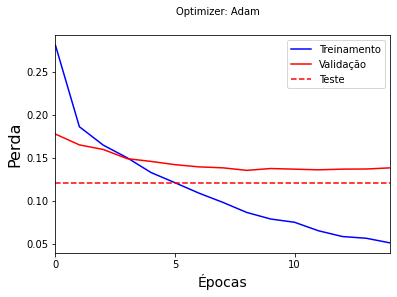

In [59]:
# Dados das épocas em números inteiros
epochs = range(len(hist_adam.history['loss']))

# Plot do gráfico
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Perda', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.plot(epochs, hist_adam.history['loss'], color='b', label='Treinamento')
plt.plot(epochs, hist_adam.history['val_loss'], color='r', label='Validação')
plt.axhline(test_acc[0], color='r', linestyle='dashed', label='Teste')
plt.legend(loc='upper right')
plt.xticks(range(min(epochs), max(epochs) + 1, 5))
plt.xlim(min(epochs), max(epochs))
plt.show()


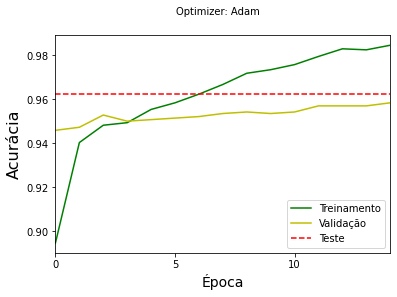

In [60]:
epochs = np.arange(len(hist_adam.history['accuracy']))

# Plot do gráfico
plt.suptitle('Optimizer: Adam', fontsize=10)
plt.ylabel('Acurácia', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.xticks(epochs)  # Defina os valores inteiros no eixo X
plt.plot(epochs, hist_adam.history['accuracy'], color='g', label='Treinamento')
plt.plot(epochs, hist_adam.history['val_accuracy'], color='y', label='Validação')
plt.axhline(test_acc[1], color='r', linestyle='dashed', label='Teste')
plt.legend(loc='lower right')
plt.xticks(range(min(epochs), max(epochs) + 1, 5))
plt.xlim(min(epochs), max(epochs))
# Exiba o gráfico
plt.show()

In [61]:
print(f'Accuracy: {metrics.accuracy_score(y_test, pred)}')
print(f'Precision: {metrics.precision_score(y_test, pred)}')
print(f'Recall: {metrics.recall_score(y_test, pred)}')
print(f'F1 Score: {metrics.f1_score(y_test, pred)}')

Accuracy: 0.9625
Precision: 0.9676966292134831
Recall: 0.9569444444444445
F1 Score: 0.9622905027932961


<AxesSubplot:>

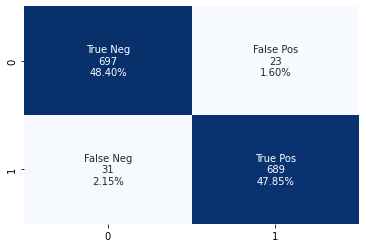

In [62]:
cm = confusion_matrix(y_test, pred).astype('int32')

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)

In [63]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       720
           1       0.97      0.96      0.96       720

    accuracy                           0.96      1440
   macro avg       0.96      0.96      0.96      1440
weighted avg       0.96      0.96      0.96      1440



### Metadados

Além dos textos dos artigos, o Fake.Br também disponibiliza todos os links e metadados, contendo informações sobre os artigos, tais como autor, data de publicação e número de visualizações. Tanto os textos dos artigos quanto seus metadados foram utilizados.

In [275]:
def read_metadata(metadata_path, label): 
    dir_metadata = glob(metadata_path + label + '-meta-information/*.txt')
    metadata = []
    
    for path in tqdm(dir_metadata):
        data = np.genfromtxt(path, delimiter = '\n', dtype = str, encoding = 'utf-8')
        if len(data) < 25:
            # print(path)
            data = np.insert(data, 0, None)
        metadata.append(data)

    metadata = np.array(metadata)
    metadata = np.c_[metadata, [label for i in range(len(metadata))]]
    
    return metadata

In [276]:
meta_fake = read_metadata(folder, 'fake')
meta_true = read_metadata(folder, 'true')
metadata = np.concatenate((meta_fake, meta_true), axis = 0)

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

In [277]:
columns = ['author', 'link', 'category', 'date', 'tokens', 'words', 'types', 'links', 'upper_case', 'verbs', 'subj_imp_verbs', 
           'nouns', 'adjectives', 'adverbs', 'modal_verbs', 'sing_first_sec_pers_pronouns', 'plural_first_pers_pronouns', 
           'pronouns', 'pausality', 'characters', 'average_sent_length', 'average_word_length', 'news_with_speeling_errors', 
           'emotiveness', 'diversity', 'label']

In [278]:
meta_df = pd.DataFrame(metadata, columns = columns)
meta_df.head()

,author,link,category,date,tokens,words,types,links,upper_case,verbs,...,plural_first_pers_pronouns,pronouns,pausality,characters,average_sent_length,average_word_length,news_with_speeling_errors,emotiveness,diversity,label
0,mrk,https://ceticismopolitico.com/2017/11/30/katia...,politica,2017-11-30,211,185,120,0,6,30,...,0,26,2.0,815,14.2308,4.40541,0.0,0.263158,0.648649,fake
1,None,https://ceticismopolitico.com/2017/11/24/dr-ra...,politica,2017-11-24,289,254,163,0,0,56,...,0,20,2.5,1205,18.1429,4.74409,0.00787402,0.241667,0.641732,fake
2,None,https://afolhabrasil.com.br/politica/reinaldo-...,politica,2017-05-23,304,275,170,0,0,45,...,0,18,1.8125,1344,17.1875,4.88727,0.00363636,0.12782,0.618182,fake
3,None,https://www.diariodobrasil.org/relatorio-assus...,politica,24/07/2017,639,572,316,1,14,87,...,0,34,2.68,3122,22.88,5.45804,0.00174825,0.229008,0.552448,fake
4,None,https://www.diariodobrasil.org/radialista-amer...,politica,25/07/2017,128,111,82,0,1,21,...,0,12,0.894737,515,5.84211,4.63964,0.0,0.269231,0.738739,fake


In [279]:
meta_df = meta_df.replace('None', np.nan)
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   author                        3599 non-null   object
 1   link                          7200 non-null   object
 2   category                      7200 non-null   object
 3   date                          7200 non-null   object
 4   tokens                        7200 non-null   object
 5   words                         7200 non-null   object
 6   types                         7200 non-null   object
 7   links                         5807 non-null   object
 8   upper_case                    7200 non-null   object
 9   verbs                         7200 non-null   object
 10  subj_imp_verbs                7200 non-null   object
 11  nouns                         7200 non-null   object
 12  adjectives                    7200 non-null   object
 13  adverbs           

In [280]:
print(meta_df['author'].value_counts())

Por G1                                                         331
Por BBC                                                        235
José Nêumanne                                                  173
Por G1, Brasília                                                86
O Estado de S.Paulo                                             71
                                                              ... 
Roberta Pennafort/RIO, O Estado de S.Paulo                       1
Por G1 DF*                                                       1
Por Vladimir Netto e Lucas Salomão, TV Globo e G1, Brasília      1
Tânia Monteiro                                                   1
Por Luiza Tenente e Vanessa Fajardo, G1                          1
Name: author, Length: 1420, dtype: int64


In [281]:
# Removendo colunas com valores nulos
cols_to_drop = ['author', 'links']
meta_df = meta_df.drop(columns = cols_to_drop)
meta_df.head()

,link,category,date,tokens,words,types,upper_case,verbs,subj_imp_verbs,nouns,...,plural_first_pers_pronouns,pronouns,pausality,characters,average_sent_length,average_word_length,news_with_speeling_errors,emotiveness,diversity,label
0,https://ceticismopolitico.com/2017/11/30/katia...,politica,2017-11-30,211,185,120,6,30,1,46,...,0,26,2.0,815,14.2308,4.40541,0.0,0.263158,0.648649,fake
1,https://ceticismopolitico.com/2017/11/24/dr-ra...,politica,2017-11-24,289,254,163,0,56,8,64,...,0,20,2.5,1205,18.1429,4.74409,0.00787402,0.241667,0.641732,fake
2,https://afolhabrasil.com.br/politica/reinaldo-...,politica,2017-05-23,304,275,170,0,45,1,88,...,0,18,1.8125,1344,17.1875,4.88727,0.00363636,0.12782,0.618182,fake
3,https://www.diariodobrasil.org/relatorio-assus...,politica,24/07/2017,639,572,316,14,87,7,175,...,0,34,2.68,3122,22.88,5.45804,0.00174825,0.229008,0.552448,fake
4,https://www.diariodobrasil.org/radialista-amer...,politica,25/07/2017,128,111,82,1,21,0,31,...,0,12,0.894737,515,5.84211,4.63964,0.0,0.269231,0.738739,fake


Para seleção das colunas de metadados a serem utilizadas, aplicou-se a técnica de Backward Feature Elimination, que consiste em iterativamente remover uma coluna por vez do conjunto completo de metadados, reavaliando o modelo a cada etapa. As colunas removidas são aquelas que não causam uma piora significativa no desempenho do modelo ou não contribuem de forma relevante para a análise, resultando em um subconjunto mais conciso e informativo de metadados. A aplicação do Backward Feature Elimination não consta neste arquivo. Além disso, foram removidas colunas que possuíam muitos valores nulos, de forma a inviabilizar a sua utilização para o treinamento dos algoritmos.

In [282]:
# Lista das colunas que deseja calcular a porcentagem em relação a 'words'
colunas_para_calcular = ['types', 'verbs', 'upper_case', 'subj_imp_verbs', 'nouns', 'modal_verbs', 'sing_first_sec_pers_pronouns', 'plural_first_pers_pronouns', 
                         'pronouns', 'adjectives', 'words']

# Converter as colunas para valores numéricos
for coluna in colunas_para_calcular:
    meta_df[coluna] = pd.to_numeric(meta_df[coluna], errors='coerce')  # Convertendo para valores numéricos

# Calcular a porcentagem para cada coluna em relação a 'words'
for coluna in colunas_para_calcular:
    meta_df[coluna] = (meta_df[coluna] / meta_df['words'])

meta_df.head()

,link,category,date,tokens,words,types,upper_case,verbs,subj_imp_verbs,nouns,...,plural_first_pers_pronouns,pronouns,pausality,characters,average_sent_length,average_word_length,news_with_speeling_errors,emotiveness,diversity,label
0,https://ceticismopolitico.com/2017/11/30/katia...,politica,2017-11-30,211,1.0,0.648649,0.032432,0.162162,0.005405,0.248649,...,0.0,0.140541,2.0,815,14.2308,4.40541,0.0,0.263158,0.648649,fake
1,https://ceticismopolitico.com/2017/11/24/dr-ra...,politica,2017-11-24,289,1.0,0.641732,0.000000,0.220472,0.031496,0.251969,...,0.0,0.078740,2.5,1205,18.1429,4.74409,0.00787402,0.241667,0.641732,fake
2,https://afolhabrasil.com.br/politica/reinaldo-...,politica,2017-05-23,304,1.0,0.618182,0.000000,0.163636,0.003636,0.320000,...,0.0,0.065455,1.8125,1344,17.1875,4.88727,0.00363636,0.12782,0.618182,fake
3,https://www.diariodobrasil.org/relatorio-assus...,politica,24/07/2017,639,1.0,0.552448,0.024476,0.152098,0.012238,0.305944,...,0.0,0.059441,2.68,3122,22.88,5.45804,0.00174825,0.229008,0.552448,fake
4,https://www.diariodobrasil.org/radialista-amer...,politica,25/07/2017,128,1.0,0.738739,0.009009,0.189189,0.000000,0.279279,...,0.0,0.108108,0.894737,515,5.84211,4.63964,0.0,0.269231,0.738739,fake


In [283]:
cols_to_drop = ['link', 'date', 'category', 'adverbs', 'plural_first_pers_pronouns',
                'average_word_length', 'sing_first_sec_pers_pronouns', 'news_with_speeling_errors',
                'average_sent_length', 'adjectives', 'tokens', 'words', 'characters']
meta_df = meta_df.drop(columns = cols_to_drop)
meta_df.head()

,types,upper_case,verbs,subj_imp_verbs,nouns,modal_verbs,pronouns,pausality,emotiveness,diversity,label
0,0.648649,0.032432,0.162162,0.005405,0.248649,0.027027,0.140541,2.0,0.263158,0.648649,fake
1,0.641732,0.000000,0.220472,0.031496,0.251969,0.043307,0.078740,2.5,0.241667,0.641732,fake
2,0.618182,0.000000,0.163636,0.003636,0.320000,0.029091,0.065455,1.8125,0.12782,0.618182,fake
3,0.552448,0.024476,0.152098,0.012238,0.305944,0.024476,0.059441,2.68,0.229008,0.552448,fake
4,0.738739,0.009009,0.189189,0.000000,0.279279,0.009009,0.108108,0.894737,0.269231,0.738739,fake


In [284]:
meta_X, meta_y = meta_df.iloc[:, :-1], meta_df['label']
meta_X_train, meta_X_test, meta_y_train, meta_y_test = train_test_split(meta_X, meta_y, 
                                                                        random_state = 42, 
                                                                        test_size = 0.2, 
                                                                        stratify = meta_y)

Muitos dos valores contidos nas colunas (até mesmo os números) estão em formado textual (strings). Desta forma, é necessário que estes valores sejam convertidos do formado textual para o formato numérico. Os rótulos também precisam ser convertidos para formatos apropriados.

In [285]:
def imputer(train, test):
    simple_imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0.0)
    transf_train = simple_imputer.fit_transform(train.ravel().reshape([len(train), 1]))
    transf_test = simple_imputer.transform(test.ravel().reshape([len(test), 1]))

    return transf_train, transf_test

for column in meta_X_train:
    meta_X_train[column], meta_X_test[column] = imputer(meta_X_train[column], meta_X_test[column])

In [286]:
lb = LabelBinarizer()
meta_y_train = lb.fit_transform(meta_y_train)
meta_y_test = lb.transform(meta_y_test)
meta_y_train, meta_y_test = meta_y_train.reshape(-1), meta_y_test.reshape(-1)


O MinMaxScaler é uma técnica de pré-processamento muito comum e útil em aprendizagem de máquina, especialmente quando se lida com algoritmos sensíveis à escala dos dados. Sua principal aplicação é redimensionar (escalar) os dados de forma que eles fiquem dentro de um intervalo específico, geralmente entre 0 e 1.

In [287]:
mm = MinMaxScaler()

meta_X_train = mm.fit_transform(meta_X_train)
meta_X_test = mm.transform(meta_X_test)

### Support Vector Machine (SVM)

In [343]:
svm_clf = SVC(kernel = 'poly', probability = True)
svm_clf.fit(meta_X_train, meta_y_train)
svm_clf.score(meta_X_test, meta_y_test)

0.9479166666666666

In [344]:
#Predict the response for test dataset
svm_prob = svm_clf.predict_proba(meta_X_test)
svm_pred = svm_clf.predict(meta_X_test)

In [345]:
print(f'Accuracy: {metrics.accuracy_score(meta_y_test, svm_pred)}')

# Model Precision: what percentage of positive tuples are labeled as such?
print(f'Precision: {metrics.precision_score(meta_y_test, svm_pred)}')

# Model Recall: what percentage of positive tuples are labelled as such?
print(f'Recall: {metrics.recall_score(meta_y_test, svm_pred)}')

print(f'F1 Score: {metrics.f1_score(meta_y_test, svm_pred)}')

Accuracy: 0.9479166666666666
Precision: 0.9448275862068966
Recall: 0.9513888888888888
F1 Score: 0.9480968858131488


<AxesSubplot:>

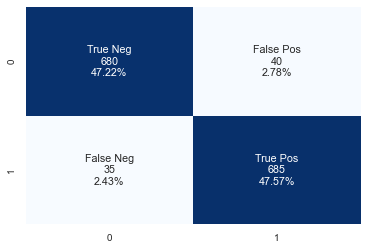

In [346]:
cm = confusion_matrix(meta_y_test, svm_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues', cbar=False)

In [347]:
print(classification_report(meta_y_test, svm_clf.predict(meta_X_test)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       720
           1       0.94      0.95      0.95       720

    accuracy                           0.95      1440
   macro avg       0.95      0.95      0.95      1440
weighted avg       0.95      0.95      0.95      1440



### Multilayer Perceptron (MLP)

In [348]:
#Create a mlp Classifier
mlp_clf = MLPClassifier(random_state=1, max_iter = 300)

#Train the model using the training sets
mlp_clf.fit(meta_X_train, meta_y_train)

mlp_clf.score(meta_X_test, meta_y_test)

0.9465277777777777

In [349]:
#Predict the response for test dataset
mlp_prob = mlp_clf.predict_proba(meta_X_test)
mlp_pred = mlp_clf.predict(meta_X_test)

In [350]:
print(f'Accuracy: {metrics.accuracy_score(meta_y_test, mlp_pred)}')

# Model Precision: what percentage of positive tuples are labeled as such?
print(f'Precision: {metrics.precision_score(meta_y_test, mlp_pred)}')

# Model Recall: what percentage of positive tuples are labelled as such?
print(f'Recall: {metrics.recall_score(meta_y_test, mlp_pred)}')

print(f'F1 Score: {metrics.f1_score(meta_y_test, mlp_pred)}')

Accuracy: 0.9465277777777777
Precision: 0.9446749654218534
Recall: 0.9486111111111111
F1 Score: 0.9466389466389467


<AxesSubplot:>

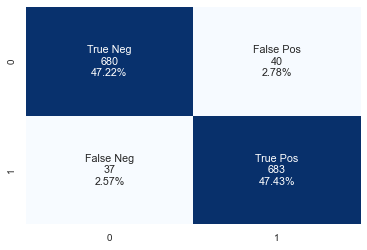

In [351]:
cm = confusion_matrix(meta_y_test, mlp_clf.predict(meta_X_test))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                    cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues', cbar=False)

### Gaussian Naine Bayes (GBN)

In [352]:
#Create a gnb Classifier
gnb_clf = GaussianNB()

#Train the model using the training sets
gnb_clf.fit(meta_X_train, meta_y_train)
gnb_clf.score(meta_X_test, meta_y_test)

0.9354166666666667

In [353]:
#Predict the response for test dataset
gnb_prob = gnb_clf.predict_proba(meta_X_test)
gnb_pred = gnb_clf.predict(meta_X_test)

In [354]:
print(f'Accuracy: {metrics.accuracy_score(meta_y_test, gnb_pred)}')

# Model Precision: what percentage of positive tuples are labeled as such?
print(f'Precision: {metrics.precision_score(meta_y_test, gnb_pred)}')

# Model Recall: what percentage of positive tuples are labelled as such?
print(f'Recall: {metrics.recall_score(meta_y_test, gnb_pred)}')

print(f'F1 Score: {metrics.f1_score(meta_y_test, gnb_pred)}')

Accuracy: 0.9354166666666667
Precision: 0.9253731343283582
Recall: 0.9472222222222222
F1 Score: 0.9361702127659575


<AxesSubplot:>

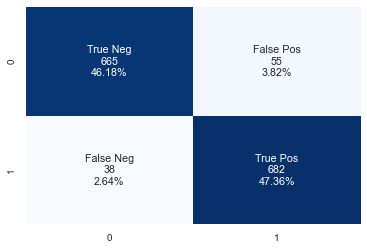

In [355]:
cm = confusion_matrix(meta_y_test, gnb_clf.predict(meta_X_test))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                    cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues', cbar=False)

### Ensemble


Após a conclusão do CNN e a seleção do melhor algoritmo (no caso, é o SVM) para a análise dos metadados, é realizada uma combinação dos resultados obtidos por ambos. Considerando que ambos os modelos geram saídas no intervalo de 0 a 1, essa inferência envolve a atribuição de pesos a esses valores. Isso permite dar maior relevância a um modelo em relação ao outro e, em seguida, realizar uma ponderação dos números calculados.

In [356]:
# define a função de perda que será otimizada
def loss_function(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# define a função que calcula as saídas do ensemble para um conjunto de entradas
def ensemble_predict(pred1, pred2, w1, w2):
    return (pred1 * w1 + pred2 * w2) / (w1 + w2)

Para a combinação, são calculados os pesos ideais que combinam as previsões de dois modelos (CNN para os textos e SVM para os metadados) em um modelo ensemble. O processo envolve a otimização dos pesos usando gradiente descendente,  considerando as previsões do ensemble e os rótulos reais. A regularização L2 é aplicada para evitar pesos excessivamente grandes, e os pesos podem ser normalizados para representar probabilidades. O objetivo é minimizar a função de perda e encontrar os pesos que melhor combinam as previsões dos modelos, contribuindo para um modelo ensemble mais eficaz.


In [357]:
def def_weights(pred1, pred2, y_train, lr=0.1, max_iter=1000, tol=0.1e-2, normalize_weights=False, lambda2=0.001):
    w1 = 0.5
    w2 = 0.5
    prev_w = np.array([w1, w2])

    for i in range(max_iter):
        ensemble_pred_train = ensemble_predict(pred1, pred2, w1, w2)
        gradient_w1 = np.mean((ensemble_pred_train - y_train) * (pred1 - ensemble_pred_train) / ((w1 + w2) ** 2))
        gradient_w2 = np.mean((ensemble_pred_train - y_train) * (pred2 - ensemble_pred_train) / ((w1 + w2) ** 2))

        # Gradientes da regularização L2
        gradient_w1 += 2 * lambda2 * w1
        gradient_w2 += 2 * lambda2 * w2

        w1 -= lr * gradient_w1
        w2 -= lr * gradient_w2

        if normalize_weights:
            w_sum = w1 + w2
            w1 /= w_sum
            w2 /= w_sum

        loss = loss_function(y_train, ensemble_pred_train) + lambda2 * (w1 ** 2 + w2 ** 2)
        
        print(f'Iteration {i + 1}, Loss: {loss:.6f}')

        curr_w = np.array([w1, w2])
        if np.linalg.norm(curr_w - prev_w) < tol:
            break
        prev_w = curr_w

    return (w1, w2)


In [358]:
pred_1 = svm_prob[:, 1]
pred_2 = text_prob[:, 0]

In [359]:
w = def_weights(pred_1, pred_2, y_test, max_iter=1000, tol = 0.1e-2, normalize_weights=True)

Iteration 1, Loss: 0.111287


In [360]:
# usa os pesos otimizados para combinar as saídas dos modelos e gerar a saída final do ensemble
ensemble_pred = [1 if pred > 0.5 else 0 for pred in ensemble_predict(pred_1, pred_2, w[0], w[1])]
ensemble_prob = ensemble_predict(pred_1, pred_2, w[0], w[1])

In [361]:
accuracy_score(y_test, ensemble_pred)

0.9680555555555556

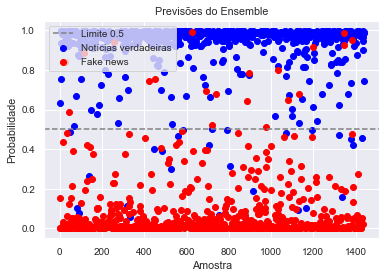

In [368]:
true_indices = np.nonzero(y_test == 1)[0]
false_indices = np.nonzero(y_test == 0)[0]
true_probabilities = ensemble_prob[true_indices]
false_probabilities = ensemble_prob[false_indices]

# Plote as previsões para os valores onde y_test é igual a 1 em azul e onde é igual a 0 em vermelho
plt.scatter(true_indices, true_probabilities, color='blue', label='Notícias verdadeiras')
plt.scatter(false_indices, false_probabilities, color='red', label='Fake news')
plt.axhline(y=0.5, color='gray', linestyle='--', label='Limite 0.5')

# Configurações de rótulos e título
plt.xlabel('Amostra')
plt.ylabel('Probabilidade')
plt.title('Previsões do Ensemble')
plt.legend(loc='upper left')
plt.show()


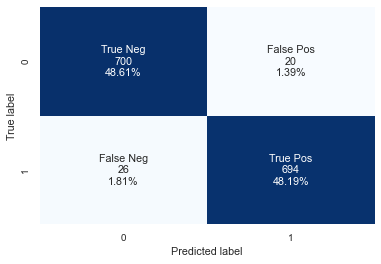

In [363]:
cm = confusion_matrix(y_test, ensemble_pred)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.set(font_scale=0.9)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [364]:
w, np.sum(w)

((0.4997125408368768, 0.5002874591631232), 1.0)

In [365]:
# Menor notícia verdadeira
pos = palavras_true.argmin()
t1 = [true_news[pos][0]]
t1 = preprocessing(t1)
t1

  0%|          | 0/1 [00:00<?, ?it/s]

['furacão irma deixa rastro destruição fotos furacão deixou mortos caribe eua siga tempo real']

In [366]:
# Maior notícia falsa
pos = palavras_fake.argmax()
t2 = [fake_news[pos][0]]
t2 = preprocessing(t2)
t2

  0%|          | 0/1 [00:00<?, ?it/s]

['próximo presidente centro-direita diz cientista político christian lohbauer vencedor eleições deverá ser geraldo alckmin joão doria outro nome perfil apareça daqui frente confira entrevista maiores autoridades brasileiras assunto ciência política senhor analisa atual quadro político país sistema gente viveu últimos anos modelo político partidário eleitoral constituição faliu presidencialismo coalizão esgotou fragmentação congresso absurda ficou comprovado então presidente dilma maioria absoluta parlamentares base governo conseguia aprovar projetos impeachment denúncias lava jato tudo gente momento depuração fim ciclo político sabe virá tempo oportunidade histórica brasil dar salto institucional caminho cheio riscos nesse ponto otimista embora caminho vá ser longo acredito haverá mudança melhor últimas pesquisas têm mostrado polarização deputado jair bolsonaro lula prognóstico próximas eleições dois cenários lula lula cenário lula acredito alcançará segundo turno perderá eleições cená

In [413]:
teste = t1 + t2
ect = tokenizer.texts_to_sequences(teste)
vocab_size = len(tokenizer.word_index) + 1
Xt = pad_sequences(ect, maxlen = max_length, padding = 'post')
Xt.shape

(model.predict(Xt) > 0.5).astype('int32')

array([[0],
       [0]])